# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
# YOUR CODE HERE
df = pd.read_csv('hdb_price_prediction.csv')
train_data = df[df['year'] <= 2019]
val_data = df[df['year'] == 2020]
test_data = df[df['year'] == 2021]

# continuous columns
continuous_cols=['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

# categorical columns
cat_embed_cols = ['month', 'town', 'flat_model_type', 'storey_range', 'full_address', 'nearest_stn', 'year']
target = ['resale_price']

train_data.drop(columns = cat_embed_cols, inplace=True)
val_data.drop(columns = cat_embed_cols, inplace=True)
test_data.drop(columns = cat_embed_cols, inplace=True)

C:\Users\Chihao Shen\AppData\Local\Temp\ipykernel_15716\407252268.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns = cat_embed_cols, inplace=True)
C:\Users\Chihao Shen\AppData\Local\Temp\ipykernel_15716\407252268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.drop(columns = cat_embed_cols, inplace=True)
C:\Users\Chihao Shen\AppData\Local\Temp\ipykernel_15716\407252268.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# YOUR CODE HERE
# process data
torch.manual_seed(SEED)
X_train = torch.tensor(train_data[continuous_cols].values).float()
y_train = torch.tensor(train_data[target].values).view(-1, 1).float()

X_test = torch.tensor(test_data[continuous_cols].values).float()
y_test = torch.tensor(test_data[target].values).view(-1, 1).float()

X_val = torch.tensor(val_data[continuous_cols].values).float()
y_val = torch.tensor(val_data[target].values).view(-1, 1).float()

# set hyperparameters as global variables
batch_size = 1024  # use batch size mentioned in B1
num_epochs = 200
learning_rate = 0.001
size_hidden1 = 5
size_hidden2 = 5
size_hidden3 = 5
no_labels = 1


# set DataLoader as global variables
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# define model
class ResaleModel(nn.Module):
    def __init__(self, no_features):
        super().__init__()
        self.lin1 = nn.Linear(no_features, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [6]:
from sklearn.metrics import mean_squared_error

# initialize model
# set loss function and optimizer as global variables
model = ResaleModel(X_train.shape[1])
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training function
def train(model_inp, num_epochs=num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

train(model)
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

Epoch [1]/[200] running accumulative loss across all batches: 13856771416260608.000
Epoch [21]/[200] running accumulative loss across all batches: 11466658111553536.000
Epoch [41]/[200] running accumulative loss across all batches: 2274735031320576.000
Epoch [61]/[200] running accumulative loss across all batches: 979318962913280.000
Epoch [81]/[200] running accumulative loss across all batches: 920953078939648.000
Epoch [101]/[200] running accumulative loss across all batches: 876217174589440.000
Epoch [121]/[200] running accumulative loss across all batches: 835358686183424.000
Epoch [141]/[200] running accumulative loss across all batches: 792032827146240.000
Epoch [161]/[200] running accumulative loss across all batches: 739703068819456.000
Epoch [181]/[200] running accumulative loss across all batches: 667902749442048.000
model err:  119000.5


In [7]:
# compare different algorithms
sa = Saliency(model)
ix = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sa_attr_test = sa.attribute(X_test)
print("sa done")
ix_attr_test = ix.attribute(X_test)
print("ix done")
ig_attr_test = ig.attribute(X_test, n_steps=50)
print("ig done")
gs_attr_test = gs.attribute(X_test, X_train)
print("gs done")
fa_attr_test = fa.attribute(X_test)
print("fa done")

d:\Program Files\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


sa done
ix done


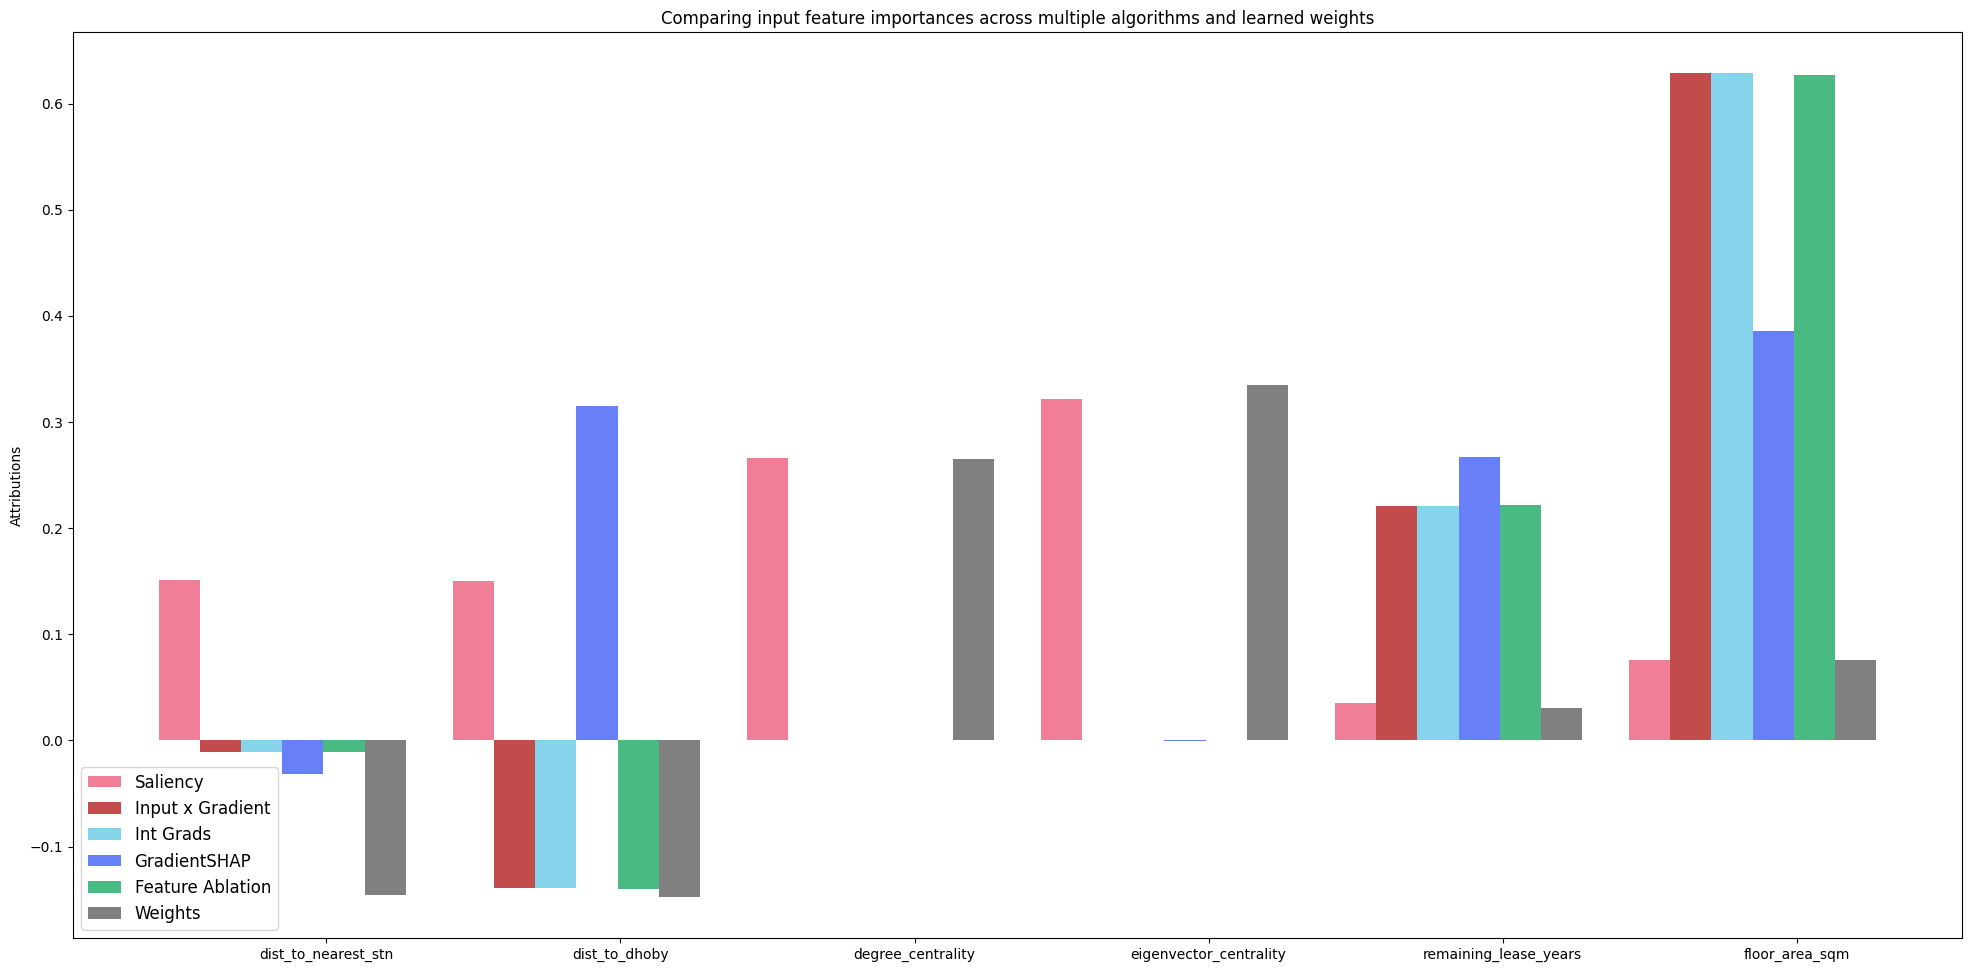

In [ ]:
import matplotlib.pyplot as plt

# plot

feature_names = train_data.drop(target, axis=1).columns.tolist()
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sa_attr_test_sum = sa_attr_test.detach().numpy().sum(0)
sa_attr_test_norm_sum = sa_attr_test_sum / np.linalg.norm(sa_attr_test_sum, ord=1)

ix_attr_test_sum = ix_attr_test.detach().numpy().sum(0)
ix_attr_test_norm_sum = ix_attr_test_sum / np.linalg.norm(ix_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Saliency', 'Input x Gradient', 'Int Grads', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sa_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ix_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [ ]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler

# scale the data
scaler = StandardScaler()

scaled_X_train = torch.tensor(scaler.fit_transform(X_train)).float()
scaled_X_val = torch.tensor(scaler.transform(X_val)).float()
scaled_X_test = torch.tensor(scaler.transform(X_test)).float()

train_dataset = torch.utils.data.TensorDataset(scaled_X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(scaled_X_test, y_test)
val_dataset = torch.utils.data.TensorDataset(scaled_X_val, y_val)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# initialize model
model = ResaleModel(X_train.shape[1])
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
train(model)
model.eval()
outputs = model(scaled_X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

Epoch [1]/[200] running accumulative loss across all batches: 13859024160161792.000
Epoch [21]/[200] running accumulative loss across all batches: 13850610663161856.000
Epoch [41]/[200] running accumulative loss across all batches: 13780962114535424.000
Epoch [61]/[200] running accumulative loss across all batches: 13552627459555328.000
Epoch [81]/[200] running accumulative loss across all batches: 13039089292935168.000
Epoch [101]/[200] running accumulative loss across all batches: 12115783278657536.000
Epoch [121]/[200] running accumulative loss across all batches: 10723341593739264.000
Epoch [141]/[200] running accumulative loss across all batches: 8976102760382464.000
Epoch [161]/[200] running accumulative loss across all batches: 7303541223849984.000
Epoch [181]/[200] running accumulative loss across all batches: 6261975097016320.000
model err:  338925.62


In [ ]:
# compare different algorithms
sa = Saliency(model)
ix = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sa_attr_test = sa.attribute(X_test)
print("sa done")
ix_attr_test = ix.attribute(X_test)
print("ix done")
ig_attr_test = ig.attribute(X_test, n_steps=50)
print("ig done")
gs_attr_test = gs.attribute(X_test, X_train)
print("gs done")
fa_attr_test = fa.attribute(X_test)
print("fa done")

d:\Program Files\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


sa done
ix done


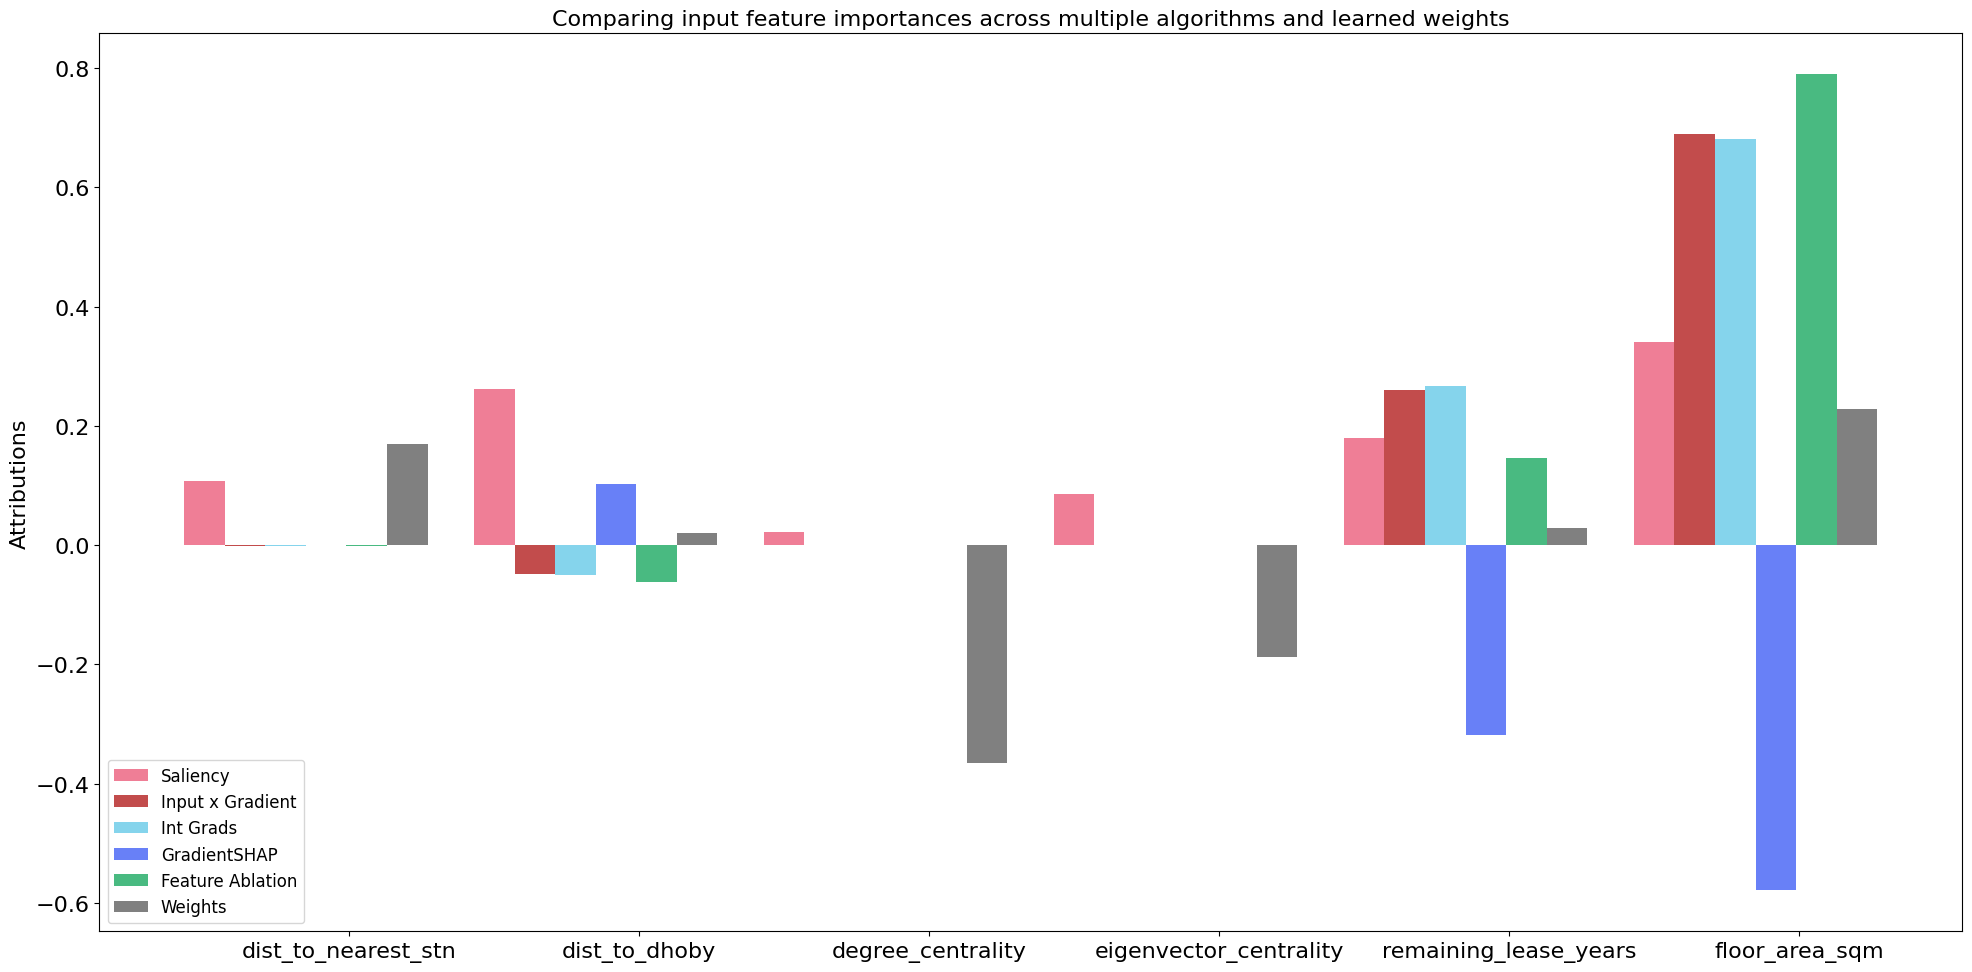

In [ ]:
import matplotlib.pyplot as plt

# plot

feature_names = train_data.drop(target, axis=1).columns.tolist()
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sa_attr_test_sum = sa_attr_test.detach().numpy().sum(0)
sa_attr_test_norm_sum = sa_attr_test_sum / np.linalg.norm(sa_attr_test_sum, ord=1)

ix_attr_test_sum = ix_attr_test.detach().numpy().sum(0)
ix_attr_test_norm_sum = ix_attr_test_sum / np.linalg.norm(ix_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Saliency', 'Input x Gradient', 'Int Grads', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sa_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ix_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)

We can observe that the GradientShap scores from the standardized data has the same direction as that without standardizing using StandardScaler. However, if the score of a feature is initially negative, then it becomes smaller in the second plot, and if it is initially positive, then it increases in magnitude after standardization in the second plot.

This is due to the baseline difference between these two settings. From the official document we know that: 
- GradientShap approximates SHAP values by computing the expectations of gradients by randomly sampling from the distribution of the given baselines (given in advance), add white noise, and then selects a random baseline from baselines’ distribution and a random point along the path between the baseline and the input.
- Most of other attribution metrics typically use a baseline of zero by default. 

From the code, we notice that the given baselines is the training data. It means the scores of GradientShap is calculated with a baseline that is around the training distribution. After scaling the data with StandardScaler, the training data has a mean of zero and a standard deviation of 1. Therefore, the baseline after scaling is near zero and the GrandientShap will now derive the scores based on how far the data is deviated from a near zero baseline, while the original baseline has a distribution around the unprocessed training data distribution and the scores are calculated using that distribution. Hence the difference occurs in some directions.

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [ ]:
# YOUR ANSWER HERE

From the official document, we know that Saliency simply returns the gradient of the output with respect to the input, which is the same as the coefficients of the first-order Taylor expansion. For Integrated Gradients, it utilizes the integral of gradients with respect to inputs along the path from a given baseline to input, and then times the difference between input and baseline. Both approaches use the gradients corresponding to the input data, therefore if the gradients from the input to the baseline is similar at different input points, and the difference between input and baseline is standardized, then IG may produce similar scores to Saliency.

However, these two scores may be quite different if the gradients varies between the input and the baseline, because Saliency only consider the input point locally, while IG presents a more comprehensive way of feature importance. Also, since the input and baseline distances are quite different for different points, it is also hard to achieve such results.

In this case, since we use linear and ReLU layers, the gradient deviation between input and baseline is small, which is similar to using only one input point by the Saliency method, thus the reason can mostly be that the distances between input and baseline vary a lot for each input. Therefore, during accumulation, different training points contribute differently according to the distance, which causes the differences of the scores between Saliency and IG metrics.

5.Why did Input x Gradients give the same attribution scores as IG?


In [ ]:
# YOUR ANSWER HERE

From the document we know that the Input X Gradient is an extension of the saliency approach, taking the gradients of the output with respect to the input and then multiplying by the input feature values.

We can observe that the scores of Input x Gradients is quite the same as IG in the second plot after standardization. This is due to the following two reasons:

1. Since we use only linear and ReLU layers in the model, we can consider the model as a linear model approximately. Therefore, the gradient between the input point and baseline (which is near zero) is almost unchanged, which is equal to the gradient of the output with respect to the input approximately.

2. Because we standardize the data such that the baseline is around zero, thus the input feature values are basically equal to the distance between input and baseline in each dimension, which is (x - x').

Thus, after multiplying the gradient and the value, the two outputs give the same distribution scores.